In [4]:
from google.colab import drive
import os
import zipfile

# Kết nối với Google Drive
drive.mount('/content/drive')

# Định nghĩa đường dẫn
project_dir = "/content/drive/MyDrive/Project_Gki"
os.makedirs(project_dir, exist_ok=True)
zip_path = os.path.join(project_dir, "StanfordCars.zip")
extracted_dir = "/content/stanford_cars"

# Giải nén file zip nếu chưa giải nén
if not os.path.exists(extracted_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print("Đã giải nén StanfordCars.zip")
else:
    print("Thư mục stanford_cars đã tồn tại, không cần giải nén.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Thư mục stanford_cars đã tồn tại, không cần giải nén.


In [5]:
!ls /content/stanford_cars

cars_annos.mat	cars_test  cars_train


In [2]:

!pip install pyvi

import json
import os
import random
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models
from PIL import Image
from pyvi import ViTokenizer

print("Đã import tất cả thư viện cần thiết!")

Đã import tất cả thư viện cần thiết!


In [16]:
!pip install transformers pillow torch

from transformers import BlipProcessor, BlipForQuestionAnswering


# Tải mô hình BLIP
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Định nghĩa danh sách câu hỏi cố định
question_templates = [
    "How many cars are in the image?",
    "What is the color of the car?",
    "What type of car is this?",
    "What brand is this car?",
    "Where is the car located?"
]

# Ánh xạ sang tiếng Việt
question_translations = {
    "How many cars are in the image?": "Có bao nhiêu xe trong ảnh?",
    "What is the color of the car?": "Màu sắc của xe là gì?",
    "What type of car is this?": "Đây là loại xe gì?",
    "What brand is this car?": "Xe này được sản xuất bởi hãng nào?",
    "Where is the car located?": "Xe trong ảnh đang ở đâu?"
}

# Hàm dịch đơn giản từ tiếng Anh sang tiếng Việt
def simple_translate(text):
    translations = {
        "one": "một", "two": "hai", "three": "ba", "four": "bốn", "five": "năm",
        "car": "xe", "red": "đỏ", "blue": "xanh dương", "green": "xanh lá",
        "black": "đen", "white": "trắng", "silver": "bạc", "gray": "xám",
        "yellow": "vàng", "sedan": "sedan", "suv": "SUV", "sports car": "xe thể thao",
        "truck": "xe tải", "toyota": "Toyota", "honda": "Honda", "bmw": "BMW",
        "mercedes": "Mercedes", "audi": "Audi", "ford": "Ford", "yes": "có",
        "no": "không", "street": "đường phố", "parking lot": "bãi đỗ xe",
        "garage": "garage", "parked": "đỗ", "moving": "di chuyển"
    }
    text_lower = text.lower()
    for en, vi in translations.items():
        if en in text_lower:
            text_lower = text_lower.replace(en, vi)
    if "xe" not in text_lower and "chiếc" not in text_lower and any(keyword in text_lower for keyword in ["một", "hai", "ba", "bốn", "năm"]):
        text_lower = text_lower.replace("một", "một chiếc xe").replace("hai", "hai chiếc xe").replace("ba", "ba chiếc xe")
    if len(text_lower) > 0:
        text_lower = text_lower[0].upper() + text_lower[1:]
    if len(text_lower) > 0 and text_lower[-1] not in [".", "!", "?"]:
        text_lower += "."
    return text_lower

# Tạo cặp câu hỏi-trả lời từ ảnh
def generate_qa_with_vqa_model(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        filename = os.path.basename(image_path)
        qa_pairs = []
        for question_en in question_templates:
            inputs = processor(image, question_en, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model.generate(**inputs)
                answer_en = processor.decode(outputs[0], skip_special_tokens=True)
            question_vi = question_translations[question_en]
            answer_vi = simple_translate(answer_en)
            qa_pairs.append({"image": filename, "question": question_vi, "answer": answer_vi})
        return qa_pairs
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path}: {str(e)}")
        return [{"image": os.path.basename(image_path), "question": "Có bao nhiêu xe trong ảnh?", "answer": "Có một chiếc xe trong ảnh."}]

# Tạo dataset từ thư mục ảnh
def create_dataset_with_vqa(image_dir, output_file, sample_size=None):
    all_qa_pairs = []
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if sample_size and sample_size < len(image_files):
        image_files = random.sample(image_files, sample_size)
    print(f"Đang tạo bộ dữ liệu từ {len(image_files)} hình ảnh...")
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        print(f"Đang xử lý ảnh {i+1}/{len(image_files)}: {image_file}")
        qa_pairs = generate_qa_with_vqa_model(image_path)
        all_qa_pairs.extend(qa_pairs)
        if (i + 1) % 10 == 0:
            with open(output_file + "_temp.json", 'w', encoding='utf-8') as f:
                json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)
    print(f"Đã tạo {len(all_qa_pairs)} cặp câu hỏi-trả lời trong file {output_file}")
    return all_qa_pairs

IMAGE_DIR = os.path.join(extracted_dir, "cars_train/cars_train")
OUTPUT_FILE = "/content/questions_answers_vqa.json"
qa_pairs = create_dataset_with_vqa(IMAGE_DIR, OUTPUT_FILE, sample_size=1000)  # Tăng lên 1000 ảnh

Đang tạo bộ dữ liệu từ 1000 hình ảnh...
Đang xử lý ảnh 1/1000: 01677.jpg
Đang xử lý ảnh 2/1000: 00959.jpg
Đang xử lý ảnh 3/1000: 04075.jpg
Đang xử lý ảnh 4/1000: 00001.jpg
Đang xử lý ảnh 5/1000: 07228.jpg
Đang xử lý ảnh 6/1000: 05322.jpg
Đang xử lý ảnh 7/1000: 04858.jpg
Đang xử lý ảnh 8/1000: 02367.jpg
Đang xử lý ảnh 9/1000: 07432.jpg
Đang xử lý ảnh 10/1000: 02913.jpg
Đang xử lý ảnh 11/1000: 06132.jpg
Đang xử lý ảnh 12/1000: 05431.jpg
Đang xử lý ảnh 13/1000: 03055.jpg
Đang xử lý ảnh 14/1000: 05185.jpg
Đang xử lý ảnh 15/1000: 06982.jpg
Đang xử lý ảnh 16/1000: 07981.jpg
Đang xử lý ảnh 17/1000: 05849.jpg
Đang xử lý ảnh 18/1000: 00345.jpg
Đang xử lý ảnh 19/1000: 06388.jpg
Đang xử lý ảnh 20/1000: 03677.jpg
Đang xử lý ảnh 21/1000: 03760.jpg
Đang xử lý ảnh 22/1000: 02826.jpg
Đang xử lý ảnh 23/1000: 00801.jpg
Đang xử lý ảnh 24/1000: 00230.jpg
Đang xử lý ảnh 25/1000: 01744.jpg
Đang xử lý ảnh 26/1000: 07196.jpg
Đang xử lý ảnh 27/1000: 01605.jpg
Đang xử lý ảnh 28/1000: 06931.jpg
Đang xử lý ảnh 29

In [24]:
# Cell 5: Định nghĩa mô hình VQA với fine-tuning CNN
# Chuẩn bị biến đổi ảnh
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Định nghĩa lớp Attention
class Attention(nn.Module):
    def __init__(self, img_dim, question_dim, hidden_dim):
        super(Attention, self).__init__()
        self.img_proj = nn.Linear(img_dim, hidden_dim)
        self.question_proj = nn.Linear(question_dim, hidden_dim)
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, img_features, question_features):
        img_proj = self.img_proj(img_features)
        question_proj = self.question_proj(question_features)
        combined = torch.tanh(img_proj + question_proj)
        attention_weights = torch.softmax(self.attention(combined), dim=1)
        attended_img = torch.sum(attention_weights * img_features, dim=1)
        return attended_img

# Định nghĩa ImageEncoder với tùy chọn fine-tuning
class ImageEncoder(nn.Module):
    def __init__(self, img_dim, fine_tune=True, fine_tune_layers=None):
        super(ImageEncoder, self).__init__()
        # Sử dụng ResNet50 pre-trained
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])  # Loại bỏ tầng fully connected cuối cùng

        # Điều chỉnh fine-tuning
        if not fine_tune:
            # Freeze toàn bộ ResNet50
            for param in self.features.parameters():
                param.requires_grad = False
        elif fine_tune and fine_tune_layers is not None:
            # Freeze các tầng đầu, chỉ fine-tune các tầng cuối
            for i, layer in enumerate(self.features):
                if i < len(self.features) - fine_tune_layers:
                    for param in layer.parameters():
                        param.requires_grad = False
                else:
                    for param in layer.parameters():
                        param.requires_grad = True

        # Tầng fully connected để giảm chiều đặc trưng về img_dim
        self.fc = nn.Linear(2048, img_dim)  # ResNet50 output là 2048

    def forward(self, images):
        features = self.features(images)  # (batch_size, 2048, 1, 1)
        features = features.view(features.size(0), -1)  # (batch_size, 2048)
        features = self.fc(features)  # (batch_size, img_dim)
        return features

# Định nghĩa QuestionEncoder
class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(QuestionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)

    def forward(self, questions):
        embedded = self.embedding(questions)
        _, (hidden, _) = self.lstm(embedded)
        return hidden.squeeze(0)

# Định nghĩa Decoder
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTMCell(embed_size + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)

    def forward(self, input_token, hidden, cell):
        embedded = self.embedding(input_token)
        lstm_input = torch.cat([embedded.squeeze(1), hidden], dim=1)
        hidden, cell = self.lstm(lstm_input, (hidden, cell))
        output = self.fc(hidden)
        return output, hidden, cell

# Định nghĩa mô hình VQA
class VQAModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, img_dim, fine_tune=True, fine_tune_layers=None):
        super(VQAModel, self).__init__()
        self.image_encoder = ImageEncoder(img_dim, fine_tune=fine_tune, fine_tune_layers=fine_tune_layers)
        self.question_encoder = QuestionEncoder(vocab_size, embed_size, hidden_size)
        self.attention = Attention(img_dim, hidden_size, hidden_size)
        self.decoder = Decoder(vocab_size, embed_size, hidden_size)
        self.vocab_size = vocab_size

    def forward(self, images, questions, answers=None, max_len=20):
        img_features = self.image_encoder(images)  # (batch_size, img_dim)
        question_features = self.question_encoder(questions)  # (batch_size, hidden_size)
        attended_img = self.attention(img_features.unsqueeze(1), question_features.unsqueeze(1))  # (batch_size, hidden_size)

        # Chuẩn bị đầu vào cho decoder
        batch_size = images.size(0)
        hidden = attended_img  # Trạng thái ban đầu cho LSTM
        cell = torch.zeros_like(hidden).to(device)
        decoder_input = torch.tensor([token_to_id['<sos>']] * batch_size).unsqueeze(1).to(device)  # (batch_size, 1)

        # Sinh chuỗi dự đoán
        outputs = []
        for t in range(max_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs.append(output)  # (batch_size, vocab_size)
            # Sử dụng teacher forcing trong huấn luyện
            if answers is not None and t < answers.size(1) - 1:
                decoder_input = answers[:, t].unsqueeze(1)
            else:
                decoder_input = output.argmax(dim=-1).unsqueeze(1)

        outputs = torch.stack(outputs, dim=1)  # (batch_size, max_len, vocab_size)
        return outputs

In [25]:
# Cell 6: Tạo từ vựng và dataset
# Hàm chuyển văn bản thành chuỗi token
def text_to_sequence(text, token_to_id):
    tokens = ViTokenizer.tokenize(text.lower()).split()
    return [token_to_id.get(token, token_to_id['<unk>']) for token in tokens]

# Tạo từ vựng từ file JSON
def build_vocab(qa_pairs):
    all_words = []
    for pair in qa_pairs:
        all_words.extend(ViTokenizer.tokenize(pair['question'].lower()).split())
        all_words.extend(ViTokenizer.tokenize(pair['answer'].lower()).split())
    word_counts = Counter(all_words)
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + [word for word, count in word_counts.items()]
    token_to_id = {token: idx for idx, token in enumerate(vocab)}
    id_to_token = {idx: token for token, idx in token_to_id.items()}
    return token_to_id, id_to_token

# Dataset cho huấn luyện
class VQADataset(Dataset):
    def __init__(self, qa_pairs, image_dir, token_to_id, max_len=20):
        self.qa_pairs = qa_pairs
        self.image_dir = image_dir
        self.token_to_id = token_to_id
        self.transform = image_transform
        self.max_len = max_len

    def __len__(self):
        return len(self.qa_pairs)

    def __getitem__(self, idx):
        pair = self.qa_pairs[idx]
        image_path = os.path.join(self.image_dir, pair['image'])
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        question = text_to_sequence(pair['question'], self.token_to_id)
        answer = text_to_sequence(pair['answer'], self.token_to_id)
        return image, question, answer

def collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)
    questions = pad_sequence([torch.tensor(q) for q in questions], batch_first=True, padding_value=token_to_id['<pad>'])
    answers = pad_sequence([torch.tensor(a) for a in answers], batch_first=True, padding_value=token_to_id['<pad>'])
    return images, questions, answers

# Load file JSON và tạo dataset
with open(OUTPUT_FILE, 'r', encoding='utf-8') as f:
    qa_pairs = json.load(f)

token_to_id, id_to_token = build_vocab(qa_pairs)
dataset = VQADataset(qa_pairs, IMAGE_DIR, token_to_id, max_len=20)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

print(f"Tạo dataset thành công với {len(dataset)} cặp câu hỏi-trả lời.")

Tạo dataset thành công với 5000 cặp câu hỏi-trả lời.


In [26]:
# Cell 7: Huấn luyện mô hình với fine-tuning CNN
# Khởi tạo mô hình với fine-tuning
model = VQAModel(
    vocab_size=len(token_to_id),
    embed_size=256,
    hidden_size=512,
    img_dim=512,
    fine_tune=True,  # Bật fine-tuning
    fine_tune_layers=2  # Chỉ fine-tune 2 tầng cuối của ResNet50
).to(device)

# Sử dụng learning rate khác nhau cho các phần của mô hình
optimizer = torch.optim.Adam([
    {'params': model.image_encoder.features.parameters(), 'lr': 1e-5},  # Learning rate nhỏ cho CNN
    {'params': model.image_encoder.fc.parameters(), 'lr': 1e-3},  # Learning rate lớn hơn cho tầng fully connected
    {'params': model.question_encoder.parameters(), 'lr': 1e-3},
    {'params': model.attention.parameters(), 'lr': 1e-3},
    {'params': model.decoder.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss(ignore_index=token_to_id['<pad>'])

# Kiểm tra trạng thái huấn luyện của các tầng trong ImageEncoder
print("Trạng thái huấn luyện của các tầng trong ImageEncoder:")
for name, param in model.image_encoder.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

# Huấn luyện mô hình
max_len = 20  # Độ dài tối đa của câu trả lời
num_epochs = 10  # Giảm số epoch để chạy nhanh hơn khi kiểm tra
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (images, questions, answers) in enumerate(dataloader):
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)

        # Đảm bảo answers có độ dài max_len
        if answers.size(1) < max_len:
            padding = torch.full((answers.size(0), max_len - answers.size(1)), token_to_id['<pad>']).to(device)
            answers = torch.cat([answers, padding], dim=1)
        elif answers.size(1) > max_len:
            answers = answers[:, :max_len]

        optimizer.zero_grad()
        outputs = model(images, questions, answers)  # (batch_size, max_len, vocab_size)
        loss = criterion(outputs.view(-1, len(token_to_id)), answers.view(-1))  # Tính loss trên tất cả các bước
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

    # Lưu mô hình sau mỗi epoch
    torch.save(model.state_dict(), f'/content/model_epoch_{epoch+1}.pth')

Trạng thái huấn luyện của các tầng trong ImageEncoder:
features.0.weight: requires_grad = False
features.1.weight: requires_grad = False
features.1.bias: requires_grad = False
features.4.0.conv1.weight: requires_grad = False
features.4.0.bn1.weight: requires_grad = False
features.4.0.bn1.bias: requires_grad = False
features.4.0.conv2.weight: requires_grad = False
features.4.0.bn2.weight: requires_grad = False
features.4.0.bn2.bias: requires_grad = False
features.4.0.conv3.weight: requires_grad = False
features.4.0.bn3.weight: requires_grad = False
features.4.0.bn3.bias: requires_grad = False
features.4.0.downsample.0.weight: requires_grad = False
features.4.0.downsample.1.weight: requires_grad = False
features.4.0.downsample.1.bias: requires_grad = False
features.4.1.conv1.weight: requires_grad = False
features.4.1.bn1.weight: requires_grad = False
features.4.1.bn1.bias: requires_grad = False
features.4.1.conv2.weight: requires_grad = False
features.4.1.bn2.weight: requires_grad = Fals

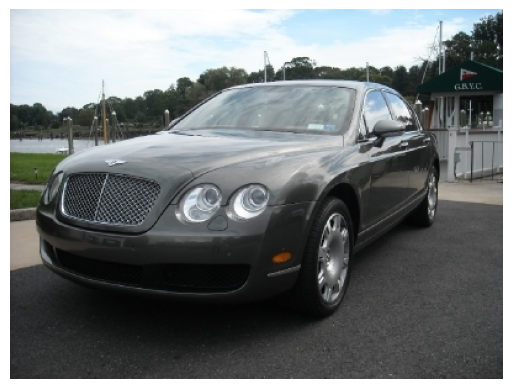

Câu hỏi: Có bao nhiêu xe trong ảnh?
Câu trả lời dự đoán: 1 . . . . . . . . . . . . . . . . . . .
Câu trả lời thực tế: 1.
--------------------------------------------------
Câu hỏi: Màu sắc của xe là gì?
Câu trả lời dự đoán: 1 . . . . . . . . . . . . . . . . . . .
Câu trả lời thực tế: Xám.
--------------------------------------------------
Câu hỏi: Đây là loại xe gì?
Câu trả lời dự đoán: 1 . . . . . . . . . . . . . . . . . . .
Câu trả lời thực tế: Chrysler.
--------------------------------------------------
Câu hỏi: Xe này được sản xuất bởi hãng nào?
Câu trả lời dự đoán: 1 . . . . . . . . . . . . . . . . . . .
Câu trả lời thực tế: Chrysler.
--------------------------------------------------
Câu hỏi: Xe trong ảnh đang ở đâu?
Câu trả lời dự đoán: 1 . . . . . . . . . . . . . . . . . . .
Câu trả lời thực tế: Bãi đỗ xe.
--------------------------------------------------


In [27]:
# Cell 8: Sửa hàm predict_answer và kiểm tra kết quả
# Hàm dự đoán câu trả lời
def predict_answer(model, image_path, question, token_to_id, id_to_token, max_len=20):
    model.eval()
    with torch.no_grad():
        # Xử lý ảnh
        image = Image.open(image_path).convert('RGB')
        image = image_transform(image).unsqueeze(0).to(device)

        # Xử lý câu hỏi
        question_seq = text_to_sequence(question, token_to_id)
        question_tensor = pad_sequence([torch.tensor(question_seq)], batch_first=True, padding_value=token_to_id['<pad>']).to(device)

        # Trích xuất đặc trưng
        img_features = model.image_encoder(image)  # (batch_size=1, img_dim)
        question_features = model.question_encoder(question_tensor)  # (batch_size=1, hidden_size)
        attended_img = model.attention(img_features.unsqueeze(1), question_features.unsqueeze(1))  # (batch_size=1, hidden_size)

        # Khởi tạo trạng thái LSTM
        hidden = attended_img  # (batch_size=1, hidden_size)
        cell = torch.zeros_like(hidden).to(device)
        decoder_input = torch.tensor([token_to_id['<sos>']]).unsqueeze(0).to(device)  # (batch_size=1, 1)

        # Sinh câu trả lời
        answer = []
        for _ in range(max_len):
            output, hidden, cell = model.decoder(decoder_input, hidden, cell)
            pred_token = output.argmax(dim=-1).item()
            if pred_token == token_to_id['<eos>']:
                break
            answer.append(id_to_token[pred_token])
            decoder_input = torch.tensor([pred_token]).unsqueeze(0).to(device)

        return ' '.join(answer)

# Kiểm tra kết quả trên một ảnh
# Chọn một ảnh mẫu từ tập dữ liệu
image_file = qa_pairs[0]['image']  # Lấy ảnh đầu tiên trong qa_pairs
image_path = os.path.join(IMAGE_DIR, image_file)

# Hiển thị ảnh
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

# Lấy tất cả câu hỏi và câu trả lời thực tế liên quan đến ảnh này
questions_for_image = [item['question'] for item in qa_pairs if item['image'] == image_file]
real_answers_for_image = [item['answer'] for item in qa_pairs if item['image'] == image_file]

# Dự đoán và hiển thị kết quả
for question, real_answer in zip(questions_for_image, real_answers_for_image):
    predicted_answer = predict_answer(model, image_path, question, token_to_id, id_to_token)
    print(f"Câu hỏi: {question}")
    print(f"Câu trả lời dự đoán: {predicted_answer}")
    print(f"Câu trả lời thực tế: {real_answer}")
    print("-" * 50)